In [422]:
import pandas as pd
import numpy as np
import shap

In [423]:
from modules import helper
from modules.log_transformer import CustomLogTransformer

# Introduction

The Titanic Spaceship project was undertaken to apply machine learning techniques to predict the outcomes of passengers aboard a hypothetical spacecraft, drawing parallels with the historical event of the Titanic. The project utilized the Kaggle [Spaceship Titanic Dataset](https://www.kaggle.com/competitions/spaceship-titanic) to achieve a benchmark accuracy of over 79% in predicting the dimensional transportation of passengers. The project successfully surpassed this benchmark, achieving an accuracy of 81.201% on the Kaggle test dataset.

The project's approach was comprehensive, involving dataset exploration, data preprocessing, and feature engineering as foundational steps. These initial activities were critical in preparing the dataset for the subsequent predictive modeling phase. During this phase, various machine learning algorithms were systematically evaluated and optimized to improve their performance, including XGBoost, Random Forest, CatBoost, and LightGBM classifiers. These algorithms were at the forefront of the project's sophisticated modeling efforts.

The evaluation of these models was thorough, utilizing key metrics like recall, precision, F1 score, and accuracy. These metrics offered a comprehensive perspective on the models' effectiveness, ensuring the selection of a model that achieved high accuracy and was also well-rounded in its predictive capabilities.

Further, the project incorporated the use of confusion matrices and ROC curves to more thoroughly evaluate the models' classification abilities, assisting in the determination of the most suitable classification threshold.

In the final analysis phase, SHAP (Shapley Additive explanations) values were utilized to delve into each feature's contribution to the model's predictions. This analysis provided more profound insights into the importance of individual features in predicting the likelihood of dimensional transportation, enriching the understanding of the model's decision-making process.


# Data Overview

First of all, we will load the dataset and take a look at the first few rows to understand the data better.

In [492]:
spaceship = pd.read_csv('train.csv')

In [425]:
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


- Shape of the dataset

In [426]:
spaceship.shape

(8693, 14)

- Checking the data types of the columns.

In [427]:
spaceship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


The spaceship dataset is relatively small. It has 8693 rows and 14 columns, six numerical and eight categorical columns. The target column is 'Transported' which is a boolean column.

## Data Cleaning

Now, we will check for missing values , duplicates and outliers in the dataset.

- Null values

In [428]:
spaceship.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Null values exist in every column except for 'PassengerId' and 'Transported.' Only when a better understanding of the data is achieved will action be taken regarding these null values.

- Duplicates

In [429]:
spaceship.duplicated().sum()

0

There are no duplicates in the dataset.

- Outliers

In [430]:
helper.detect_outliers_percentile(spaceship, cols_to_check=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], lower_percentile=5,
                                  upper_percentile=95)

Number of outliers in Age: 0
Sample size for Age: 8514
Number of outliers in RoomService: 0
Sample size for RoomService: 8512
Number of outliers in FoodCourt: 0
Sample size for FoodCourt: 8510
Number of outliers in ShoppingMall: 0
Sample size for ShoppingMall: 8485
Number of outliers in Spa: 0
Sample size for Spa: 8510
Number of outliers in VRDeck: 0
Sample size for VRDeck: 8505


There are no outliers in the dataset.

Now we will create new columns of existing ones and drop the columns that are not required.
Passengerid column contains two values groub number, and passenger number in that group, if we would split this columnes we would able to understand group sizes
Cabin columns contains information, of deck, number and side of the cabin, we can split this column to get more information about the cabin.

In [431]:
spaceship[['GroupNumber', 'PassengerNumber']] = spaceship['PassengerId'].str.split('_', expand=True)

In [432]:
spaceship[['Deck', 'Num', 'Side']] = spaceship['Cabin'].str.split('/', expand=True)

In [433]:
spaceship['Num'] = pd.to_numeric(spaceship['Num'], errors='coerce', downcast='integer')

In [434]:
spaceship = spaceship.drop(['PassengerId', 'Cabin'], axis=1)

# Exploratory Data Analysis

## Categorical Variables

- Target Variable

First, we will examine the distribution of the target variable 'Transported.'

In [435]:
spaceship['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

Target variable is balanced.

- Relationship between 'Transported' and other categorical variables

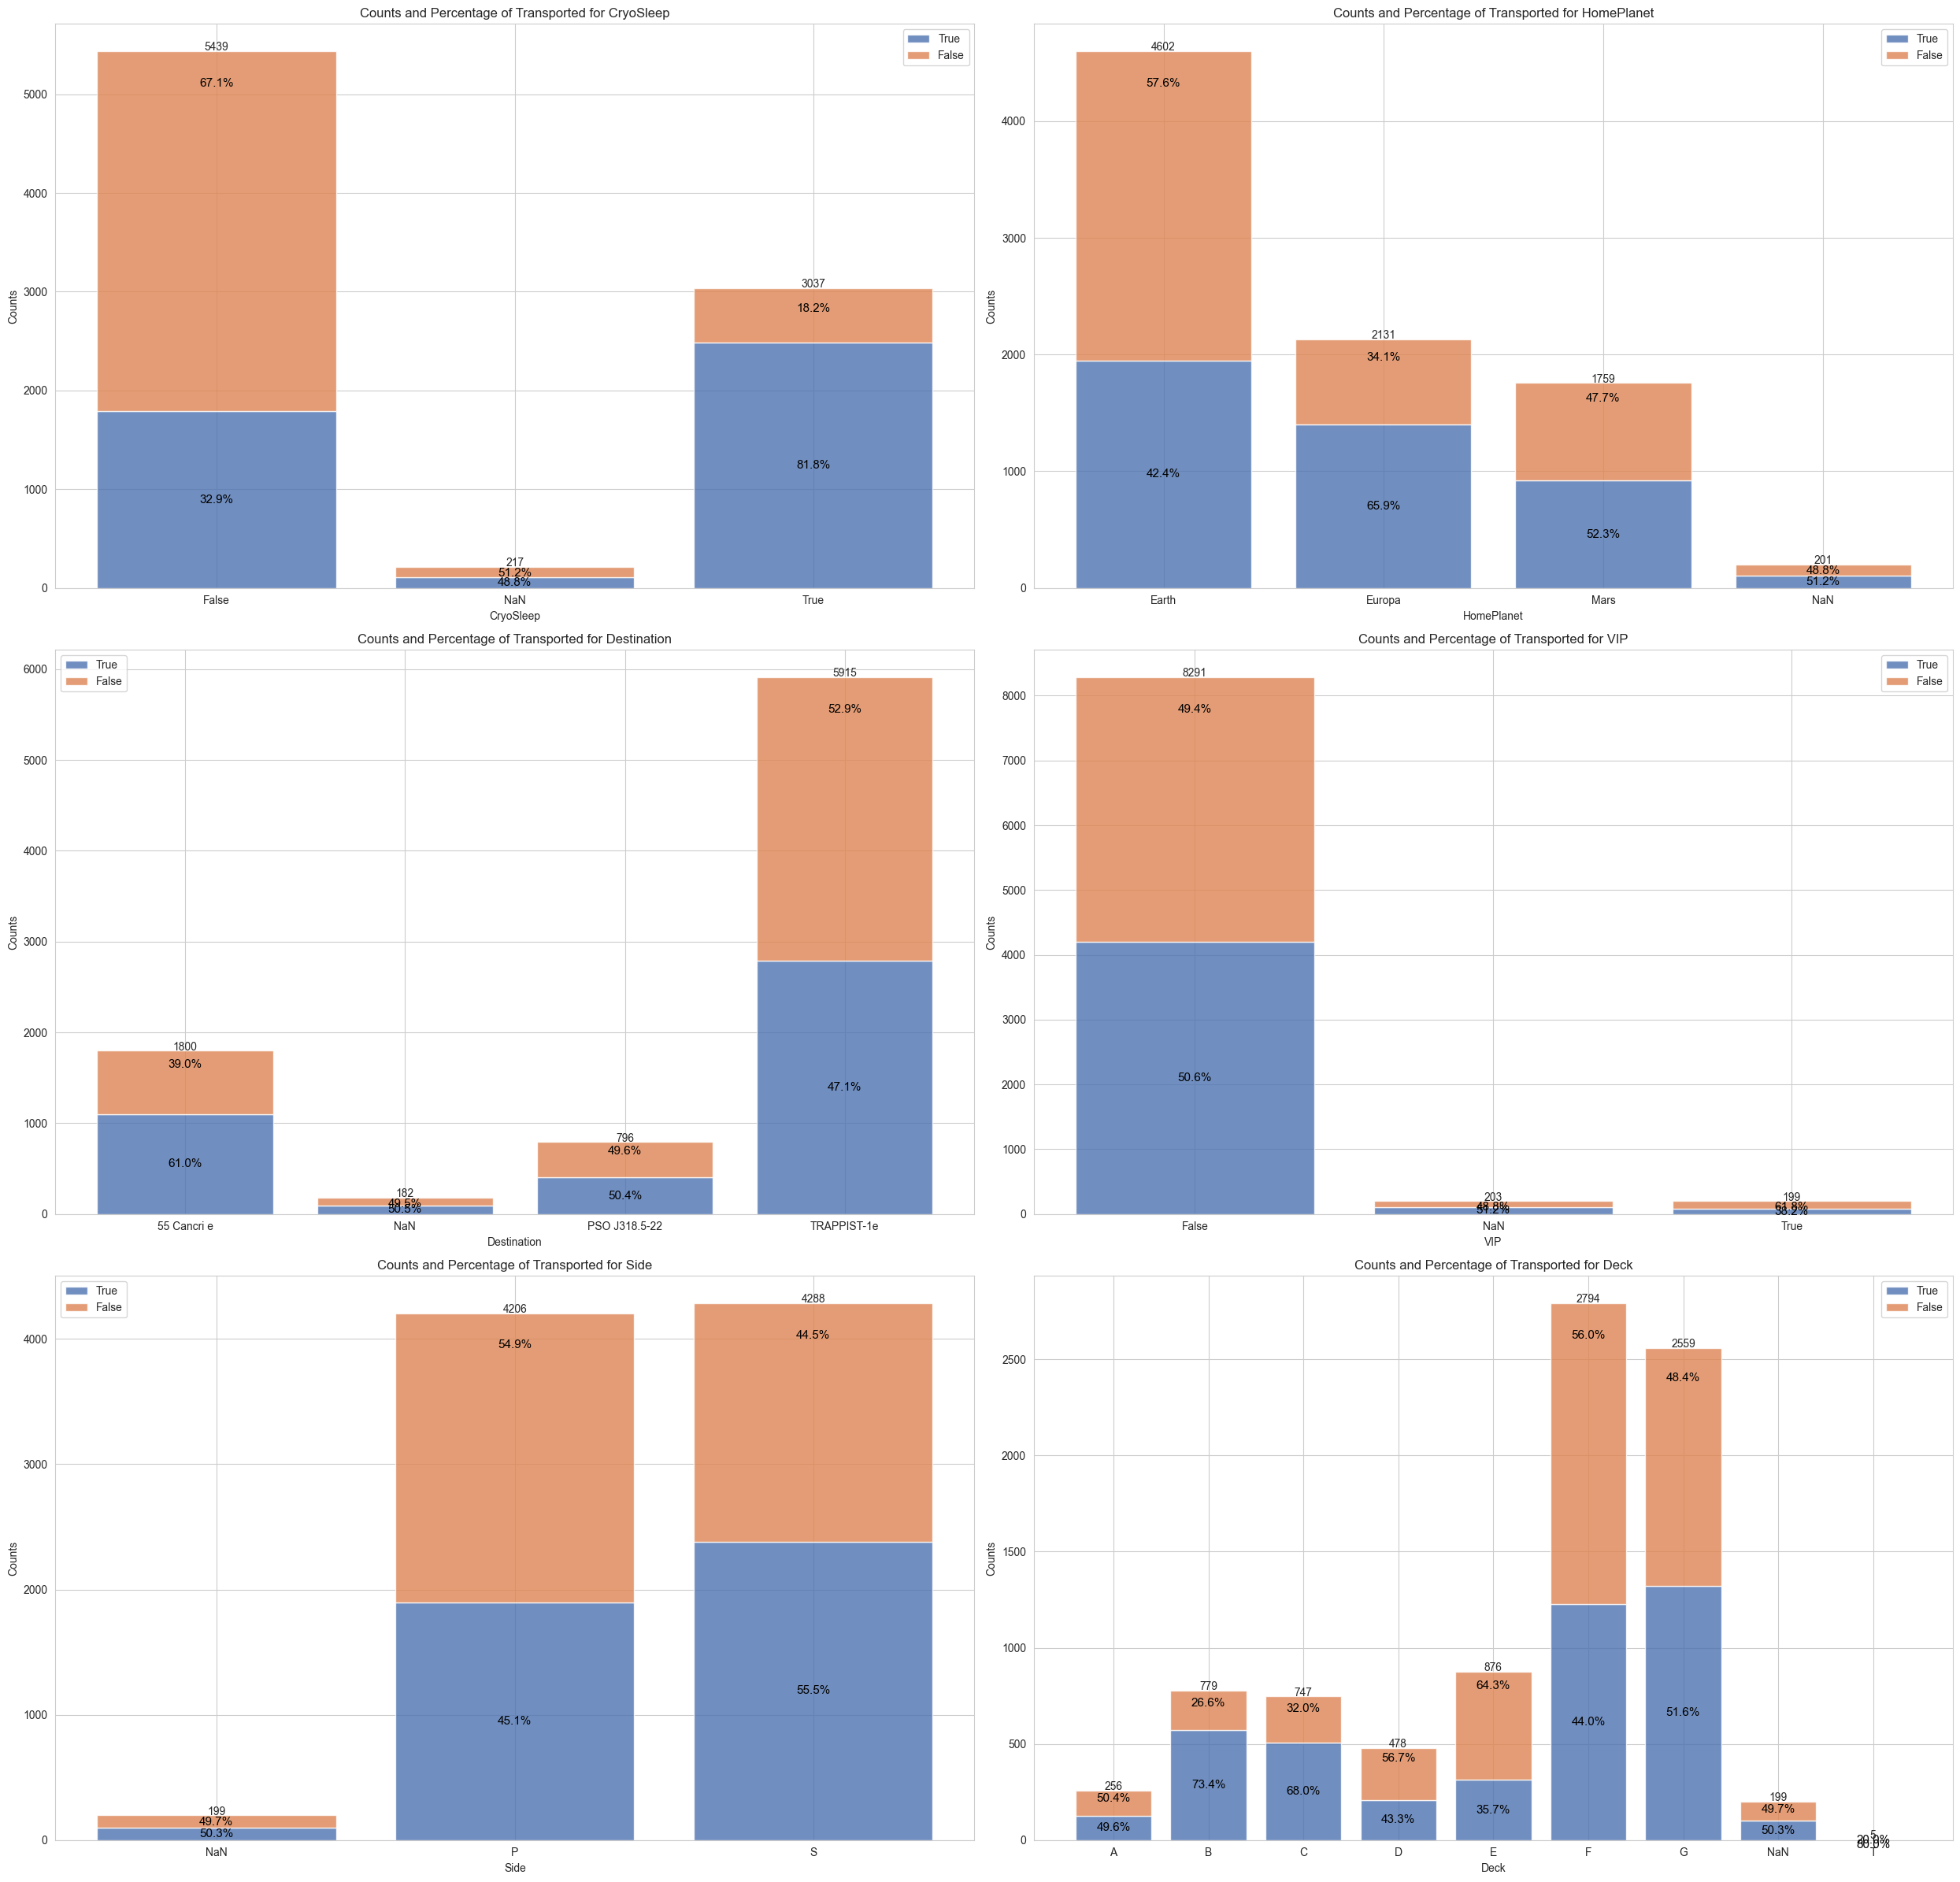

In [436]:
helper.plot_categorical_distribution(spaceship,
                                     variables=['CryoSleep', 'HomePlanet', 'Destination', 'VIP', 'Side', 'Deck'],
                                     target='Transported')

The data reveals intriguing insights. For instance, 81% of passengers who underwent CryoSleep were transported, while 19% were not. Furthermore, 73% of passengers from deck B and 68% from deck C were transported. Interestingly, 65% of passengers from Europa were transported, but 64% from deck E were not. We will now examine combinations of features. The creation of new features might aid in improving our target predictions. Also important to note is that in all categorical variables, where values were Nan, distribution was even for transported and not transported.

We will remove Vip column, because there are very few people who had vip status, and we will remove deck T, because it has only few values.
Removing columns like 'VIP' and 'Deck T' with few unique values or imbalanced distributions benefits machine learning models by:

1. **Reducing Overfitting**: Limits learning from noise, enhancing generalization.
2. **Improving Performance**: Focuses on more informative attributes, potentially boosting model accuracy.
3. **Enhancing Efficiency**: Reduces computational complexity, speeding up training and prediction.
4. **Increasing Interpretability**: Simplifies the model, making it easier to understand and explain.

In [437]:
spaceship = spaceship.drop('VIP', axis=1)

spaceship = spaceship[spaceship['Deck'] != 'T']

- Deck

We saw that the highest percentage of passengers who were transported were from deck B and C. We will now examine more about these decks

In [438]:
planet_deck_count = spaceship.groupby(['HomePlanet', 'Deck']).size().unstack().fillna(0).astype(int)
planet_deck_count

Deck,A,B,C,D,E,F,G
HomePlanet,,,,,,,
Earth,0,0,0,0,395,1614,2498
Europa,252,766,734,186,128,0,0
Mars,0,0,0,282,330,1110,0


In [439]:
destination_deck_count = spaceship.groupby(['Destination', 'Deck']).size().unstack().fillna(0).astype(int)
destination_deck_count

Deck,A,B,C,D,E,F,G
Destination,,,,,,,
55 Cancri e,108,333,317,113,116,398,365
PSO J318.5-22,2,3,13,17,41,241,461
TRAPPIST-1e,142,426,405,338,696,2088,1688


Sitting people are only from Europa in the A, B, and C decks, and in the G decks, they are just from Earth. It is helpful information about how to fill out nan values.

Let's check the percentage of people in cryosleep in each deck; maybe in some decks, people were more in cryosleep and transported more.

In [440]:
deck_cryosleep_count = (spaceship.groupby(['Deck', 'CryoSleep'])
                        .size()
                        .unstack(fill_value=0)
                        .astype(int))

deck_cryosleep_count['True_Percentage'] = (deck_cryosleep_count[True] / 
                                           (deck_cryosleep_count[True] + deck_cryosleep_count[False])) * 100
deck_cryosleep_count

CryoSleep,False,True,True_Percentage
Deck,,,
A,182,68,27.200000
B,341,419,55.131579
C,430,294,40.607735
D,364,104,22.222222
E,688,168,19.626168
F,2176,550,20.176082
G,1146,1350,54.086538


The percentage of people in B or C deck who had cryosleep and were transported.

In [441]:
cryo_bc_transported = (spaceship[(spaceship['CryoSleep'] == True) & (spaceship['Deck'].isin(['B', 'C']))]
                   .groupby('Transported')
                   .size()
                   .pipe(lambda s: s / s.sum() * 100)
                   .rename({True: 'True_Percentage', False: 'False_Percentage'}))

cryo_bc_transported

Transported
False_Percentage     0.701262
True_Percentage     99.298738
dtype: float64

The DataFrame indicates that passengers who were in cryosleep and were from either deck B or C had an almost certain probability of being transported. This is a significant observation. The next step is to generate a new feature that merges 'Deck' and 'CryoSleep'.

In [442]:
spaceship['CryoSleep_deck_BC'] = ((spaceship['CryoSleep'] == True) & spaceship['Deck'].isin(['B', 'C'])).astype(int)

- Destination

We will now examine the relationship between 'Destination 55 cancri e who had cryosleep and transported

In [443]:
cryo_destination_55 = (spaceship[(spaceship['CryoSleep'] == True) & (spaceship['Destination'] == '55 Cancri e')]
                .groupby('Transported')
                .size()
                .pipe(lambda s: pd.DataFrame({'Count': s, 'Percentage': s / s.sum() * 100})))
cryo_destination_55

,Count,Percentage
Transported,,
False,53,7.171854
True,686,92.828146


In [444]:
spaceship['CryoSleep_destination_55'] = ((spaceship['CryoSleep'] == True) & (spaceship['Destination'] == '55 Cancri e')).astype(int)

Now we will check if this new column adds extra value or duplicates with the CryoSleep_deck_BC column

In [445]:
both_one = (spaceship['CryoSleep_deck_BC'] & spaceship['CryoSleep_destination_55']).sum()
at_least_one_not_one = ((spaceship['CryoSleep_deck_BC'] != spaceship['CryoSleep_destination_55']) & (spaceship['CryoSleep_deck_BC'] | spaceship['CryoSleep_destination_55'])).sum()

both_one, at_least_one_not_one

(348, 756)

## Numerical Variables

In [446]:
spaceship.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,CryoSleep_deck_BC,CryoSleep_destination_55
count,8509.000000,8507.000000,8505.000000,8481.000000,8505.000000,8500.000000,8489.000000,8688.000000,8688.000000
mean,28.823128,224.568591,457.524985,173.810871,310.140976,304.514706,600.720344,0.082067,0.085060
std,14.491737,666.699661,1611.596911,604.827351,1134.406644,1145.750474,511.811565,0.274483,0.278987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.000000,0.000000,0.000000
75%,38.000000,46.500000,76.000000,27.000000,59.000000,45.000000,999.000000,0.000000,0.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000,1.000000,1.000000


### Age

First, we will examine the distribution of the 'Age' column.

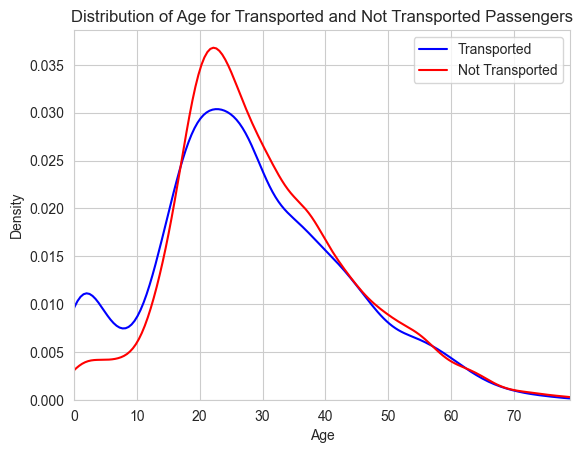

In [447]:
helper.plot_age_distribution(spaceship, 'Age')

We could see that there are diffence of transported and not transported people in different age groups, we will create a new column 'Age_Category' which will have age groups and we will check the distribution of transported and not transported people in each age group.

In [448]:
spaceship['Age_Category'] = pd.cut(spaceship['Age'], 
                                   bins=[0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80], 
                                   labels=['0-5', '5-10', '10-15', '15-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80'], 
                                   include_lowest=True)

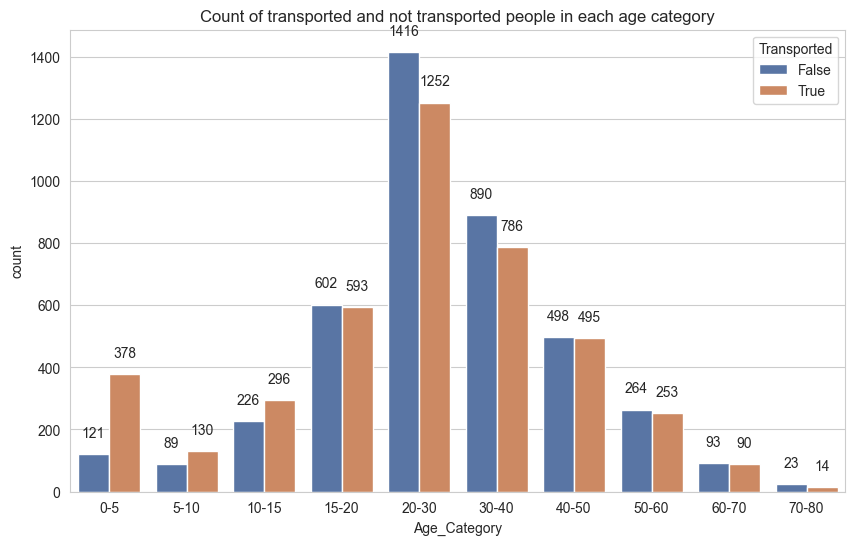

In [449]:
helper.plot_count(spaceship, 'Age_Category', 'Transported', 'Count of transported and not transported people in each age category')

### Services

We will create new column Totalservices which will be sum of all services columns

In [450]:
spaceship['TotalServices'] = spaceship[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

Lets check if anyone who were in cryosleep used services

In [451]:
cryosleep_true_and_services = spaceship[(spaceship['CryoSleep'] == True) & (spaceship['TotalServices'] > 0.0)]

print(len(cryosleep_true_and_services))

0


Everyone who were in crypsleep didnt have services. This is a significant observation. It would help to understand best way to replace nan values in these columns, if cryo sleep is true and there are nan values in any of these columns 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' then we can replace them with 0.

Now lets look how much who werent in cryosleep and didnt use services were transported

In [452]:
cryosleep_false_and_services = spaceship[(spaceship['CryoSleep'] == False) & (spaceship['TotalServices'] == 0.0)]

percentage_transported = round((len(cryosleep_false_and_services[cryosleep_false_and_services['Transported'] == True]) / len(cryosleep_false_and_services)) * 100, 2)

print(f"The percentage of passengers who were not in cryosleep, had no services, and were transported is {percentage_transported}%")

The percentage of passengers who were not in cryosleep, had no services, and were transported is 61.58%


Percentage of people who were transported of each used services

In [453]:
service_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalServices']

percentage_transported_per_service = {
    service: round((len(spaceship[(spaceship[service] > 0.0) & (spaceship['Transported'] == True)]) / len(spaceship[spaceship[service] > 0.0])) * 100, 2)
    for service in service_columns
}

for service, percentage in percentage_transported_per_service.items():
    print(f"The percentage of passengers who used {service} and were transported is {percentage}%")

The percentage of passengers who used RoomService and were transported is 26.01%
The percentage of passengers who used FoodCourt and were transported is 34.57%
The percentage of passengers who used ShoppingMall and were transported is 31.72%
The percentage of passengers who used Spa and were transported is 27.76%
The percentage of passengers who used VRDeck and were transported is 27.55%
The percentage of passengers who used TotalServices and were transported is 29.87%


Because everyone in Cryosleep didn't use services, analyzing service distribution between people who weren't in Cryptsleep is more logical. So, we will filter out just those not in cryo sleep and analyze the distribution of services they used.

In [454]:
cryosleep_false = spaceship[spaceship['CryoSleep'] == False]

In [455]:
cryosleep_false.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,CryoSleep_deck_BC,CryoSleep_destination_55,TotalServices
count,5339.000000,5324.000000,5325.000000,5331.000000,5322.000000,5316.000000,5327.000000,5435.0,5435.0,5435.000000
mean,29.645814,350.331893,712.353052,270.789158,484.576663,475.499812,614.974094,0.0,0.0,2246.310580
std,14.079068,803.338485,1970.908779,741.997518,1393.536439,1404.415454,525.209245,0.0,0.0,3244.714361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,171.000000,0.0,0.0,745.500000
50%,27.000000,3.000000,5.000000,2.000000,7.000000,4.000000,438.000000,0.0,0.0,1019.000000
75%,38.000000,390.250000,532.000000,242.000000,353.750000,356.000000,1027.500000,0.0,0.0,2415.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000,0.0,0.0,35987.000000


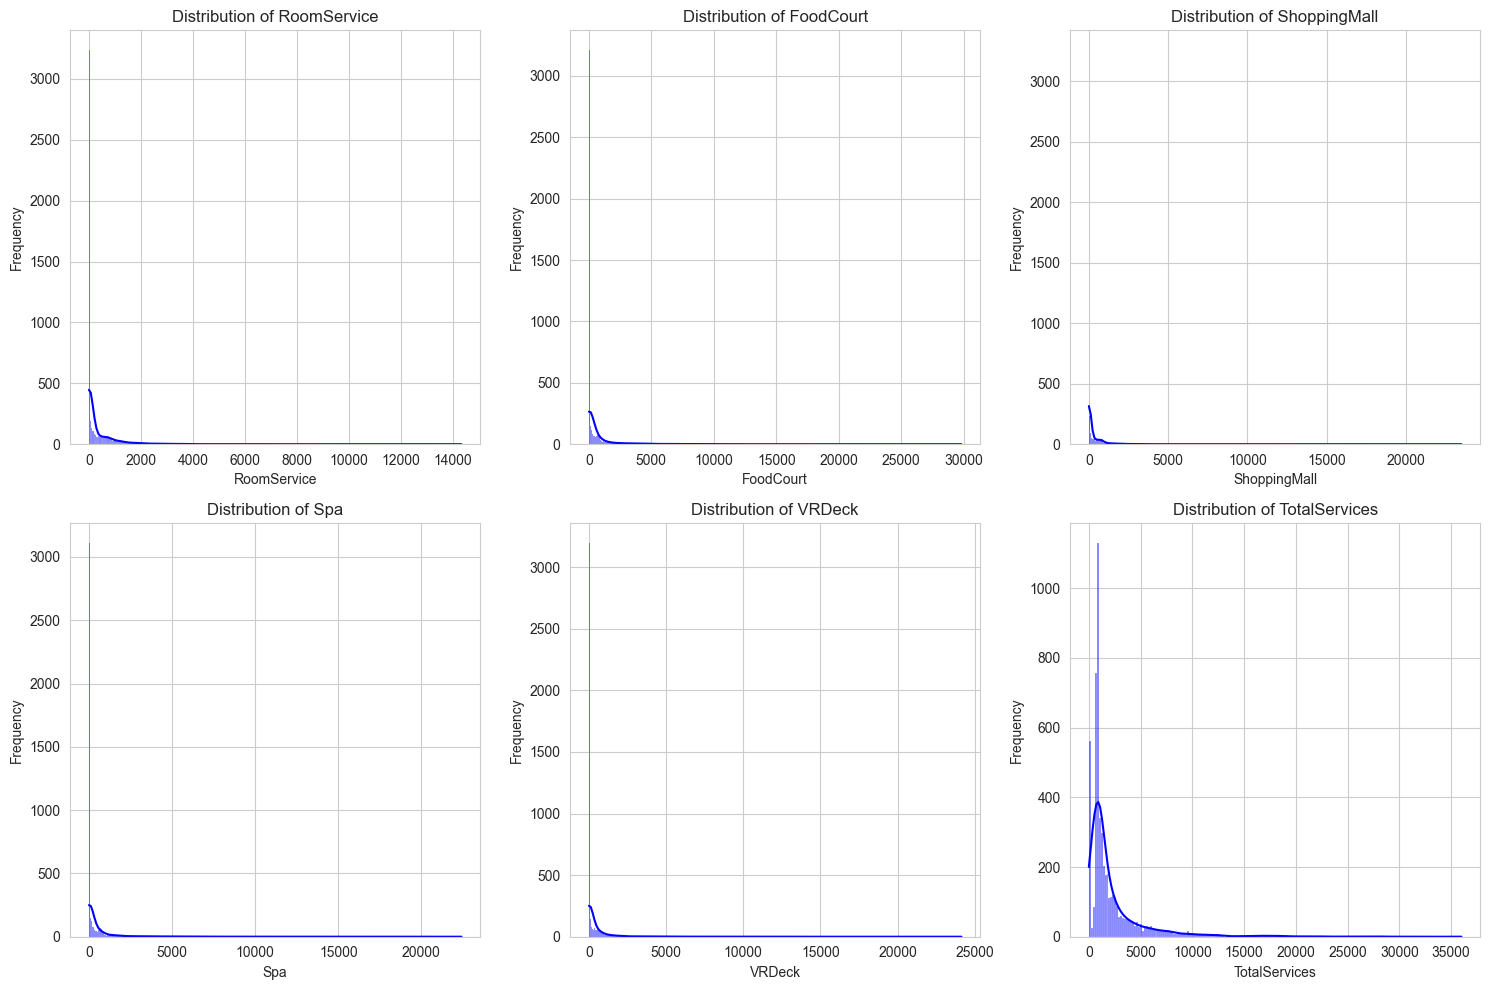

In [456]:
helper.plot_histograms(cryosleep_false, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalServices'])

Data is skewed; we will apply log transformation to these columns and recheck the distribution.

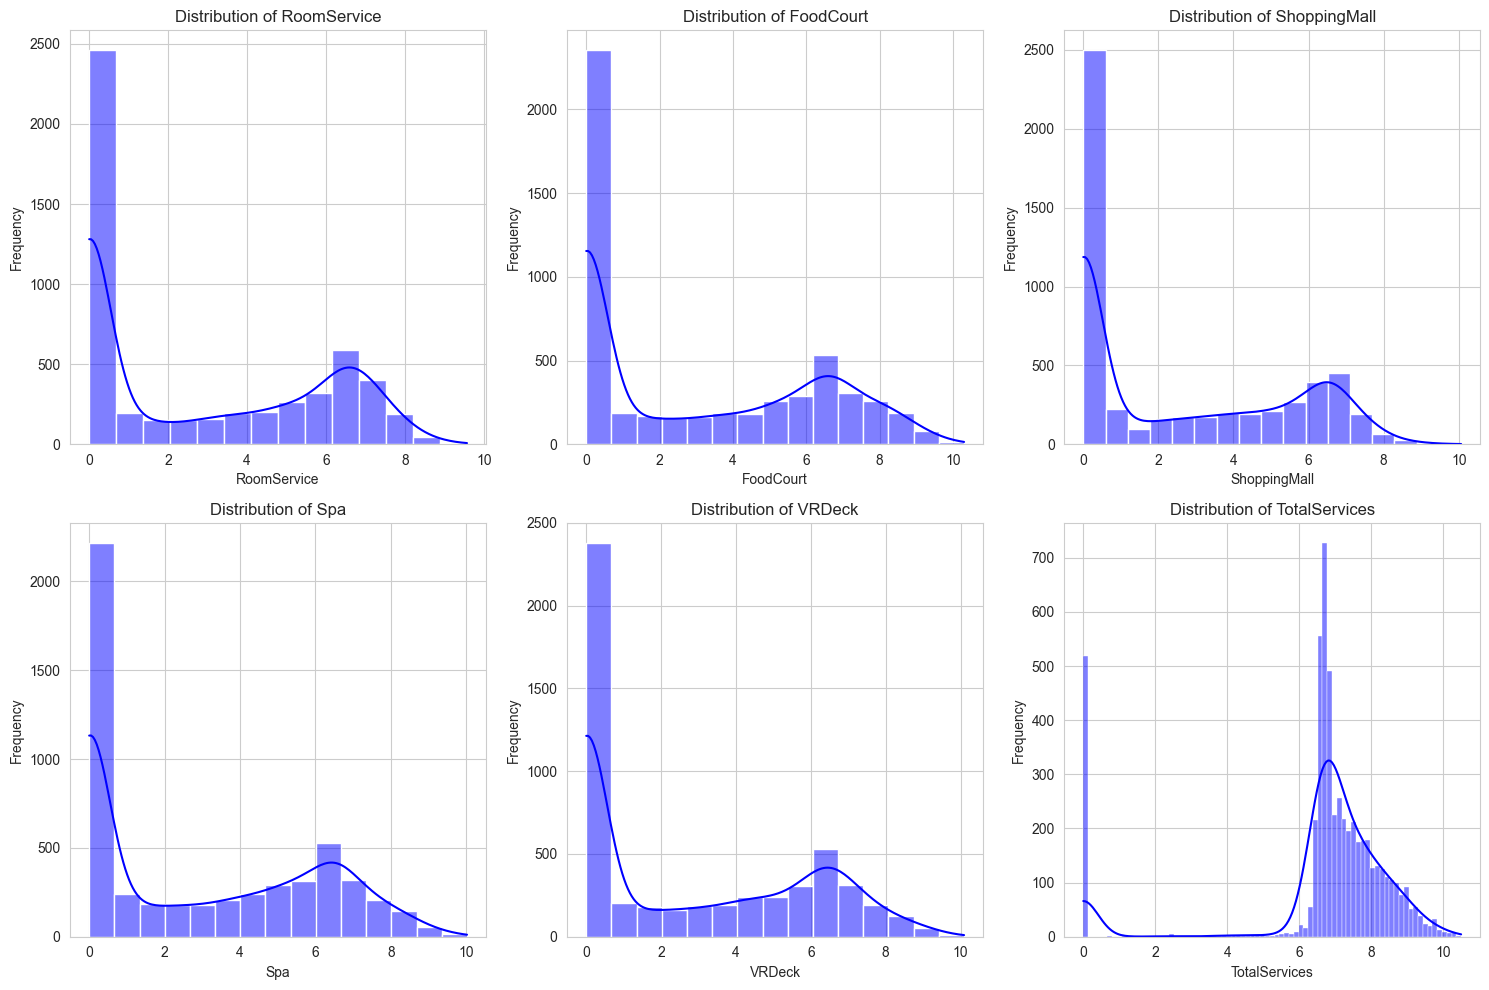

In [457]:
helper.plot_histograms(cryosleep_false, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalServices'], use_log=True)

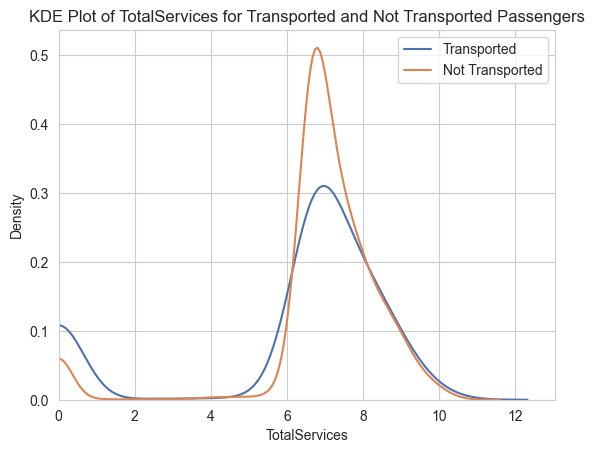

In [458]:
helper.plot_kde(cryosleep_false, 'TotalServices', use_log=True)

The KDE plot and histogram observations indicate similar spending patterns across all services. The analysis further reveals a lower transportation rate for individuals with total service values between 6 and 8, while those who either did not incur any service expenses or spent minimally exhibited a higher likelihood of being transported.
Consequently, a new column named 'ServiceCategory' will be introduced to categorize the total services.

In [459]:
spaceship['log_total_services'] = pd.cut(np.log1p(spaceship['TotalServices']),
                                      bins=[-np.inf, 0, 2, 4, 6, 8, np.inf],
                                      labels=['0', '0-2', '2-4', '4-6', '6-8', '8+'])

### Groups

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

We will examine whether the number of passengers transported varies according to their group size.

In [460]:
spaceship['GroupSize'] = spaceship.groupby('GroupNumber')['PassengerNumber'].transform('count')

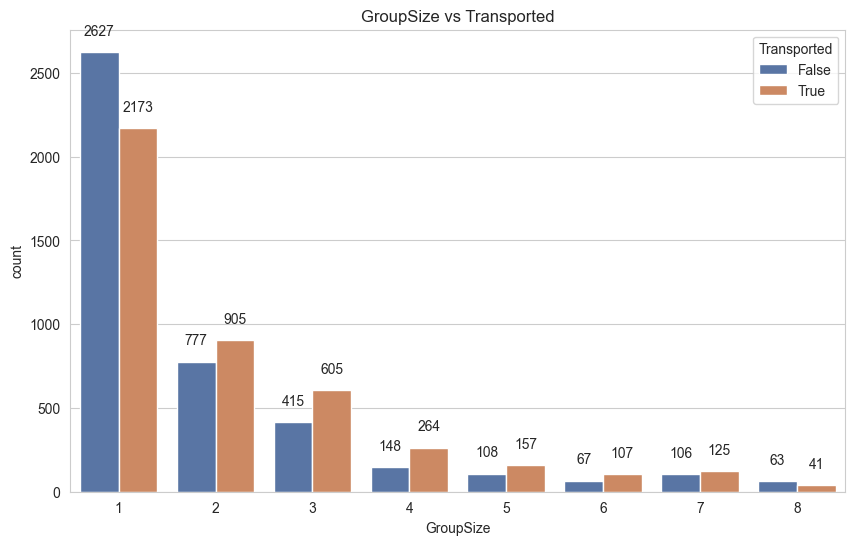

In [461]:
helper.plot_count(spaceship, 'GroupSize', 'Transported', 'GroupSize vs Transported')

There were differences depending on the group size people belonged to, whether they were transported or not. We will leave this new feature; it might add extra value to our model.

### Correlation

Our dataset comprises both numerical and categorical data. We will use the Phi-K correlation coefficient to measure the correlation between the features and the target variable. The Phi-K correlation is a robust, entropy-based correlation ratio that works with categorical and numerical variables. It is an extension of the Pearson correlation coefficient, which only works with numerical variables.

The Phi-K correlation coefficient is designed to measure the strength of association between two variables, ranging from 0 to 1, where 0 indicates no correlation and 1 indicates a perfect correlation. It does not provide values for negative correlations, as it does not measure the direction of the relationship, only the strength. 

To ensure more accurate results from the Phi-K correlation analysis, it's recommended that rows containing NaN values be removed from the dataset. This preprocessing step helps to clarify the associations between variables. 

In [462]:
spaceship_cleaned = spaceship.dropna()

In [463]:
spaceship_cleaned.shape

(6769, 22)

interval columns not set, guessing: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'CryoSleep_deck_BC', 'CryoSleep_destination_55', 'TotalServices', 'GroupSize']


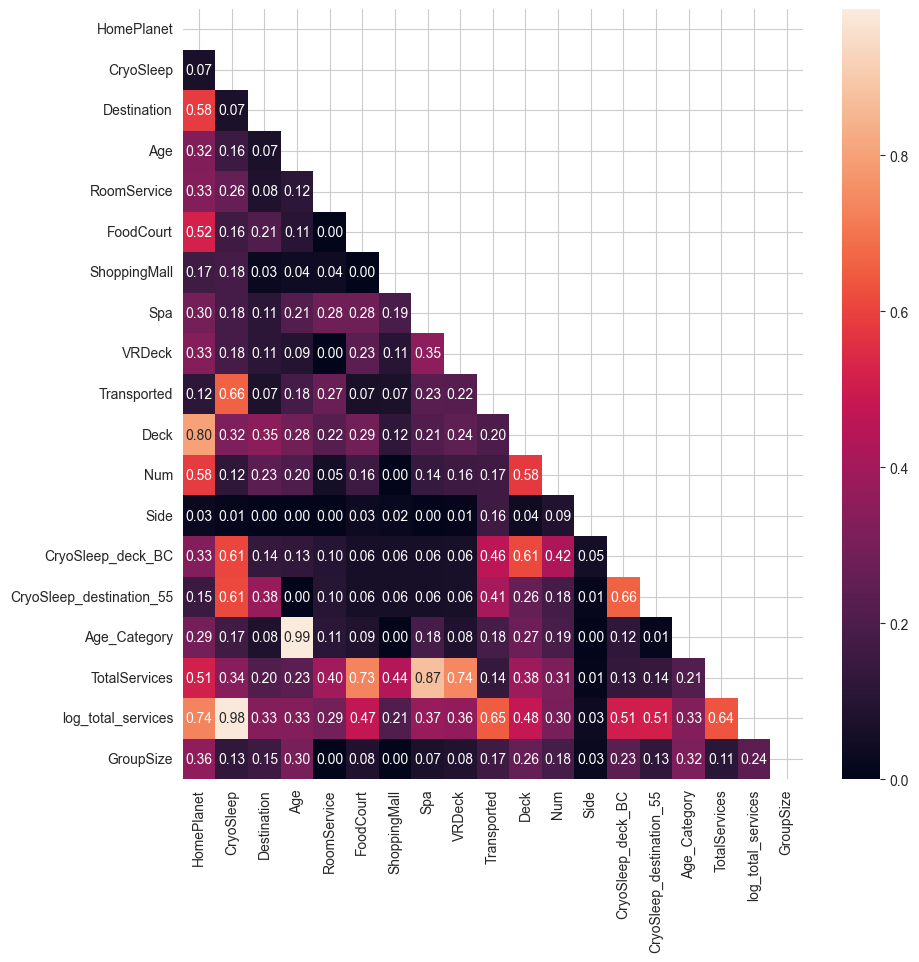

In [464]:
helper.plot_phik(spaceship_cleaned, columns_to_drop=['GroupNumber', 'Name', 'GroupNumber' , 'PassengerNumber'])

The Phi-K correlation analysis reveals the following insights:

 - The highest correlation with transported has 'CryoSleep', ServiceCategory, CryoSleep_deck_BC, CryoSleep_destination_55

 - The lowest correlation with transported has 'Destination,' 'HomePlanet,' 'FoodCourt ShoppingMall

## Summary of EDA

The Exploratory Data Analysis (EDA) for the Titanic Spaceship project, using the Kaggle Spaceship Titanic Dataset, provided several key insights into the data, which were crucial for feature engineering and model development. Here's a summary of the findings:

1. **Data Overview and Cleaning**:
   - The dataset consists of 8693 rows and 14 columns, with a mix of numerical and categorical data. The target variable is 'Transported', indicating whether a passenger was transported to another dimension.
   - Missing values were present in almost every column except 'PassengerId' and 'Transported'. No duplicates were found in the dataset.
   - Outliers were checked but not found to be significant in the numerical columns.

2. **Feature Engineering**:
   - New features were created by splitting 'PassengerId' and 'Cabin' columns to extract more information like 'GroupNumber', 'PassengerNumber', 'Deck', 'Num', and 'Side'.
   - A 'GroupSize' feature was introduced to represent the number of people in a group, derived from 'PassengerId'.
   - 'CryoSleep_deck_BC' and 'CryoSleep_destination_55' were created to capture passengers in cryosleep on specific decks or heading to a particular destination, showing a strong correlation with the 'Transported' status.

3. **Exploratory Data Analysis**:
   - Categorical variables analysis showed significant insights, such as a high transportation rate for passengers in cryosleep and those from specific decks (B and C).
   - The 'VIP' and 'Deck T' columns were removed due to their limited variation and potential to introduce bias.
   - Numerical variables were analyzed, revealing the distribution of ages and the creation of an 'Age_Category' feature to better understand age-related transportation trends.
   - A 'TotalServices' feature summed the services used by passengers, and its relationship with the 'Transported' status was explored. It was found that passengers in cryosleep did not use services, influencing the handling of missing values in service-related columns.
   - In addition to the previously mentioned features, a new categorical feature named log_total_services was derived from the logarithmic transformation of the TotalServices feature. This transformation aimed to normalize the distribution of total services used by passengers, categorizing them into bins for more nuanced analysis. The bins were defined as follows: '0' for no services used, '0-2' for minimal usage, '2-4', '4-6', '6-8' for moderate to high usage, and '8+' for the highest usage category. This categorization facilitates the identification of patterns related to the utilization of services and their impact on the likelihood of being transported.

4. **Correlation Analysis**:
   - The Phi-K correlation analysis was conducted after removing rows with NaN values to ensure accuracy. It highlighted the strongest and weakest correlations with the 'Transported' status, guiding feature selection for modeling.



## Filling Missing Values

Based on the Exploratory Data Analysis (EDA), it was observed that cryosleep passengers did not utilize any services. Therefore, NaN values in service-related columns can be replaced with 0 for passengers marked as being in cryosleep. Additionally, if the sum of services for a passenger is greater than 0, and the cryosleep status is NaN, it can be inferred that the passenger was not in cryosleep. Thus, the NaN value for cryosleep can be set to False.

In [465]:
service_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

spaceship.loc[spaceship['CryoSleep'] == True, service_columns] = spaceship.loc[spaceship['CryoSleep'] == True, service_columns].fillna(0)

spaceship['TotalServices'] = spaceship[service_columns].sum(axis=1)

spaceship.loc[(spaceship['TotalServices'] > 0) & (spaceship['CryoSleep'].isnull()), 'CryoSleep'] = False

spaceship['TotalServices'] = spaceship[service_columns].sum(axis=1)

We will fill Nan values in deck side num columns; if a person is in the group, we will fill the missing values with the most frequent value in that group.

In [466]:
def fill_mode(x):
    """
    Calculate the mode of a given Series, excluding NaN values.
    
    Parameters:
    - x (pd.Series): A pandas Series for which the mode is calculated.
    
    Returns:
    - The mode value if it exists, otherwise np.nan.
    """
    mode_val = x.mode().dropna()
    return mode_val.iloc[0] if not mode_val.empty else np.nan

# Applying the fill_mode function to fill missing values in 'Deck', 'Num', and 'Side' columns
for column in ['Deck', 'Num', 'Side']:
    """
    For each specified column, calculate the mode within each group identified by 'GroupNumber'.
    Then, fill missing values in that column with the calculated mode for its group.
    """
    mode_series = spaceship.groupby('GroupNumber')[column].transform(fill_mode)
    spaceship.loc[spaceship[column].isnull(), column] = mode_series[spaceship[column].isnull()]

We saw that in A, B, and C decks, people were only from Europa, so we will fill the missing values in the home planet with Europa if the deck is A, B, or C. and also, if the deck is g nan values, we will fill with Earth

In [467]:
spaceship.loc[(spaceship['Deck'].isin(['A','B', 'C'])) & (spaceship['HomePlanet'].isnull()), 'HomePlanet'] = 'Europa'
spaceship.loc[(spaceship['Deck'] == 'G') & (spaceship['HomePlanet'].isnull()), 'HomePlanet'] = 'Earth'

# Machine learning models

We will use the following machine learning models to predict transported or not based on the given features:

1. **XGBoost Classifier**: XGBoost, short for eXtreme Gradient Boosting, is an ensemble learning method that uses the gradient boosting framework at its core. It operates by building multiple weak prediction models, typically decision trees, and combining them to create a strong predictive model. The "extreme" in XGBoost refers to the model's design to push the limit of computational resources for boosted tree algorithms, which is why it is known for its efficiency and effectiveness in classification tasks. It also includes a regularization parameter to prevent overfitting, which makes it more robust than standard gradient boosting.

2. **Random Forest Classifier**: Random Forest is a versatile ensemble learning method that can be used for both classification and regression tasks. It operates by creating a 'forest' of decision trees, each trained on a random subset of the training data. Each tree in the forest makes a prediction, and the class that gets the most votes becomes the model's prediction. This method is known for its robustness and ability to handle complex, high-dimensional data. It also mitigates the overfitting problem common in single decision trees.

3. **CatBoost Classifier**: CatBoost is a gradient boosting library developed by Yandex. It stands for "Category Boosting", highlighting its high performance and support for categorical features. Like other gradient boosting algorithms, CatBoost combines multiple weak learners to create a strong learner. It has a unique algorithm to handle categorical variables, which can often be challenging for machine learning models. It converts categorical values into numbers using various statistics on combinations of categorical features and their interaction with numerical features.

4. **LightGBM Classifier**: LightGBM, short for Light Gradient Boosting Machine, is a gradient boosting framework developed by Microsoft. It is designed to be fast and efficient, both in terms of computational speed and memory usage. Unlike other gradient boosting algorithms that grow trees horizontally (level-wise), LightGBM grows trees vertically (leaf-wise), choosing the leaf with the maximum delta loss to grow, which can result in better accuracy. It can handle large datasets and deal with the curse of dimensionality better than other models.

We will evaluate the performance of these models using the following metrics:

1. **Recall**: The ability of the model to correctly identify positive samples. It is calculated as the ratio of true positives to the sum of true positives and false negatives.
2. **Precision**: The ability of the model to correctly identify positive samples. It is calculated as the ratio of true positives to the sum of true positives and false positives.
3. **F1 Score**: The harmonic mean of precision and recall. It provides a balance between precision and recall.
4. **Accuracy**: The ratio of correctly predicted samples to the total number of samples. It provides an overall measure of model performance.

We will train the models on the training set, tune the hyperparameters using the validation set, and evaluate the performance on the test set. We will use the accuracy metric as the primary evaluation metric, because for Kaggle competition we need to achieve 79%+ accuracy.

Let's start by preparing the data for training the machine learning models.

## Data Preparation

We will prepare the data for training the machine learning models by performing the following steps:

1. **Map Boolean Values**: Map 'True' to 1 and 'False' to 0 in the 'CryoSleep' and 'Transported' columns.
2. **Log Transformation**: Apply log transformation to the columns 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', and 'TotalServices'.
3. **Split the Data**: Split the data into training, validation, and test sets using an 80-10-10 split.
4. **Preprocessing**: Define the preprocessing steps for the numerical and categorical features using pipelines.

In [468]:
spaceship['CryoSleep'] = spaceship['CryoSleep'].map({True: 1, False: 0})

spaceship['Transported'] = spaceship['Transported'].map({True: 1, False: 0})

In [469]:
log_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalServices']

log_transformer = CustomLogTransformer(log_columns)

In [470]:
from sklearn.model_selection import train_test_split

y = spaceship['Transported']

X = spaceship.drop(columns=['Transported', 'Name', 'GroupNumber', 'PassengerNumber'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [471]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


numeric_transformer = make_pipeline(
    KNNImputer(n_neighbors=3),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

log_transformer_pipeline = make_pipeline(
    CustomLogTransformer(log_columns),
    KNNImputer(n_neighbors=3),
    StandardScaler()
)

numeric_features = [col for col in X_train.select_dtypes(include=['int64', 'float64']).columns if col not in log_columns]
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (log_transformer_pipeline, log_columns) 
)

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['CryoSleep', 'Age', 'Num', 'GroupSize']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['HomePlanet', 'Destination', 'Deck', 'Side']),
                                ('pipeline-3',
                                 Pipeline(steps=[('customlogtransformer',
                                                  CustomLogTransformer(columns=['RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck',
                                                                                'TotalServices'])),
                                                 ('knnimputer',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['RoomService', 'FoodCourt', 'ShoppingMall',
                                  'Spa', 'VRDeck', 'TotalServices'])])

Data is now ready for training the machine learning models. We will now proceed with training the models and evaluating their performance.

## Model Training

In [472]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import optuna
import logging
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

models = {
    "XGBClassifier": make_pipeline(preprocessor, XGBClassifier(random_state=42)),
    "RandomForestClassifier": make_pipeline(preprocessor, RandomForestClassifier(random_state=42)),
    "CatBoostClassifier": make_pipeline(preprocessor, CatBoostClassifier(random_state=42, verbose=False)),
    "LGBMClassifier": make_pipeline(preprocessor, LGBMClassifier(random_state=42, verbose=-1)),
}

In [473]:
final_report = helper.generate_classification_reports(models, X_train, y_train, X_val, y_val)

In [474]:
final_report

precision    recall  f1-score     support
XGBClassifier          0              0.788155  0.802784  0.795402  431.000000
                       1              0.802326  0.787671  0.794931  438.000000
                       accuracy       0.795167  0.795167  0.795167    0.795167
                       macro avg      0.795240  0.795228  0.795167  869.000000
                       weighted avg   0.795297  0.795167  0.795165  869.000000
RandomForestClassifier 0              0.769575  0.798144  0.783599  431.000000
                       1              0.793839  0.764840  0.779070  438.000000
                       accuracy       0.781358  0.781358  0.781358    0.781358
                       macro avg      0.781707  0.781492  0.781334  869.000000
                       weighted avg   0.781805  0.781358  0.781316  869.000000
CatBoostClassifier     0              0.804762  0.784223  0.794360  431.000000
                       1              0.792873  0.812785  0.802706  438.000000
                       accuracy       0.798619  0.798619  0.798619    0.798619
                       macro avg      0.798817  0.798504  0.798533  869.000000
                       weighted avg   0.798770  0.798619  0.798566  869.000000
LGBMClassifier         0              0.797203  0.793503  0.795349  431.000000
                       1              0.797727  0.801370  0.799544  438.000000
                       accuracy       0.797468  0.797468  0.797468    0.797468
                       macro avg      0.797465  0.797437  0.797447  869.000000
                       weighted avg   0.797467  0.797468  0.797464  869.000000

CatBoostClassifier has the highest accuracy on the validation set. We will now fine-tune the hyperparameters of the CatBoostClassifier model using Optuna, a hyperparameter optimization framework.

## Hyperparameter Tuning

### Explanation of Parameters for Hyperparameter Tuning in CatBoostClassifier

1. **loss_function (`Logloss`)**:
   - **Description**: Specifies the function used to measure the error between the predicted values and the actual values. `Logloss` is commonly used for binary classification tasks.
   - **Default Value**: Varies by model, but for CatBoostClassifier, `Logloss` is a common default for binary classification.
   - **Impact on Accuracy**: Minimizing the `Logloss` directly impacts the model's ability to accurately predict binary outcomes. A lower `Logloss` indicates a model that makes predictions with higher confidence.

2. **learning_rate**:
   - **Description**: Determines the step size at each iteration while moving toward a minimum of the loss function. It controls how much the model is adjusted at each step of the boosting process.
   - **Default Value**: Typically around `0.1`, but it can vary depending on the specific implementation.
   - **Impact on Accuracy**: A smaller learning rate requires more boosting rounds but can lead to a more accurate model by allowing it to learn more nuanced patterns. Conversely, a larger learning rate speeds up training but can overshoot the minimum loss.

3. **depth**:
   - **Description**: The maximum depth of the trees. It specifies how deep each tree can grow during any boosting round.
   - **Default Value**: Usually `6`, but this can vary. Deeper trees can model more complex patterns.
   - **Impact on Accuracy**: Deeper trees can capture more complex relationships in the data but also risk overfitting. Shallower trees are faster to train and can generalize better but might miss complex patterns.

4. **iterations**:
   - **Description**: The number of boosting rounds or the number of trees to build. It controls how many times the boosting process is repeated.
   - **Default Value**: Often set to `1000`, but this can vary. More iterations allow for more complex models.
   - **Impact on Accuracy**: More iterations can lead to a more accurate model by allowing it to iteratively correct its mistakes. However, too many iterations can lead to overfitting.

5. **l2_leaf_reg (L2 Regularization Coefficient)**:
   - **Description**: This parameter controls the L2 regularization term on the weights. It's used to penalize large weights to prevent overfitting.
   - **Default Value**: Typically `3`. The exact default can vary depending on the implementation.
   - **Impact on Accuracy**: Higher values of L2 regularization can prevent overfitting by making the model simpler, but setting it too high can lead to underfitting and reduce the model's ability to capture the underlying pattern.

Tuning these parameters involves finding a balance between model complexity (which can capture more information from the data) and the risk of overfitting (which makes the model less generalizable). The optimal values often depend on the specific characteristics of the data and the problem being solved.

In [475]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    param = {
        "loss_function": trial.suggest_categorical('loss_function', ['Logloss']),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
    }

    pipe = make_pipeline(preprocessor, CatBoostClassifier(**param, random_state=42, verbose=False))
    return cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1, scoring="accuracy").mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print(study.best_params)

{'loss_function': 'Logloss', 'learning_rate': 0.02783354106744634, 'depth': 6, 'iterations': 979, 'l2_leaf_reg': 0.09448831641248268}



The Optuna tuning process slightly adjusted the learning rate and significantly reduced the L2 regularization coefficient from their default values. The number of iterations was also slightly reduced, while the loss function and depth remained at their default settings, indicating these were already well-suited for the task.

In [476]:
best_params = study.best_params

In [477]:
best_model = make_pipeline(preprocessor, CatBoostClassifier(**best_params, random_state=42, verbose=False))

best_model.fit(X_train, y_train)

y_pred_hyper = best_model.predict(X_val)

best_model_report_dict = classification_report(y_val, y_pred_hyper, output_dict=True, zero_division=1)

best_model_report_df = pd.DataFrame(best_model_report_dict).transpose()

best_model_report_df.index = pd.MultiIndex.from_product([['Cat Hypertuned'], best_model_report_df.index])

final_report = pd.concat([final_report, best_model_report_df])

In [478]:
accuracy_rows = final_report.loc[(slice(None), 'accuracy'), :]
accuracy_rows

,,precision,recall,f1-score,support
XGBClassifier,accuracy,0.795167,0.795167,0.795167,0.795167
RandomForestClassifier,accuracy,0.781358,0.781358,0.781358,0.781358
CatBoostClassifier,accuracy,0.798619,0.798619,0.798619,0.798619
LGBMClassifier,accuracy,0.797468,0.797468,0.797468,0.797468
Cat Hypertuned,accuracy,0.798619,0.798619,0.798619,0.798619


The CatBoostClassifier model with hyperparameter tuning achieved same accuracy of 0.798 on the validation set. We will now evaluate this model on the test set.

## Test Set Evaluation

In [479]:
y_pred_test = best_model.predict(X_test)

y_pred_test = best_model.predict(X_test)

test_report_dict = classification_report(y_test, y_pred_test, output_dict=True, zero_division=1)

test_report_df = pd.DataFrame(test_report_dict).transpose()

test_report_df.index = pd.MultiIndex.from_product([['Cat Hypertuned TEST'], test_report_df.index])

test_report = test_report_df

test_report

precision    recall  f1-score     support
Cat Hypertuned TEST 0              0.817972  0.823666  0.820809  431.000000
                    1              0.825287  0.819635  0.822451  438.000000
                    accuracy       0.821634  0.821634  0.821634    0.821634
                    macro avg      0.821630  0.821650  0.821630  869.000000
                    weighted avg   0.821659  0.821634  0.821637  869.000000

The CatBoostClassifier model with hyperparameter tuning achieved an accuracy of 0.8216 on the test set, reaching the goal of 79+ accuracy. We will now proceed with the model evaluation and interpretation.

# Confusion Matrix

A confusion matrix is a tool that helps visualize the performance of a classification model. It's a two-dimensional matrix where each row represents the instances of an actual class and each column represents the instances of a predicted class.

The four outcomes in a confusion matrix are:  
- True Positives (TP): The cases in which the model predicted yes (they have the condition), and they do have the condition.
- True Negatives (TN): The cases in which the model predicted no (they do not have the condition), and they do not have the condition.
- False Positives (FP): The cases in which the model predicted yes, but they do not actually have the condition. Also known as "Type I error".
- False Negatives (FN): The cases in which the model predicted no, but they actually do have the condition. Also known as "Type II error".

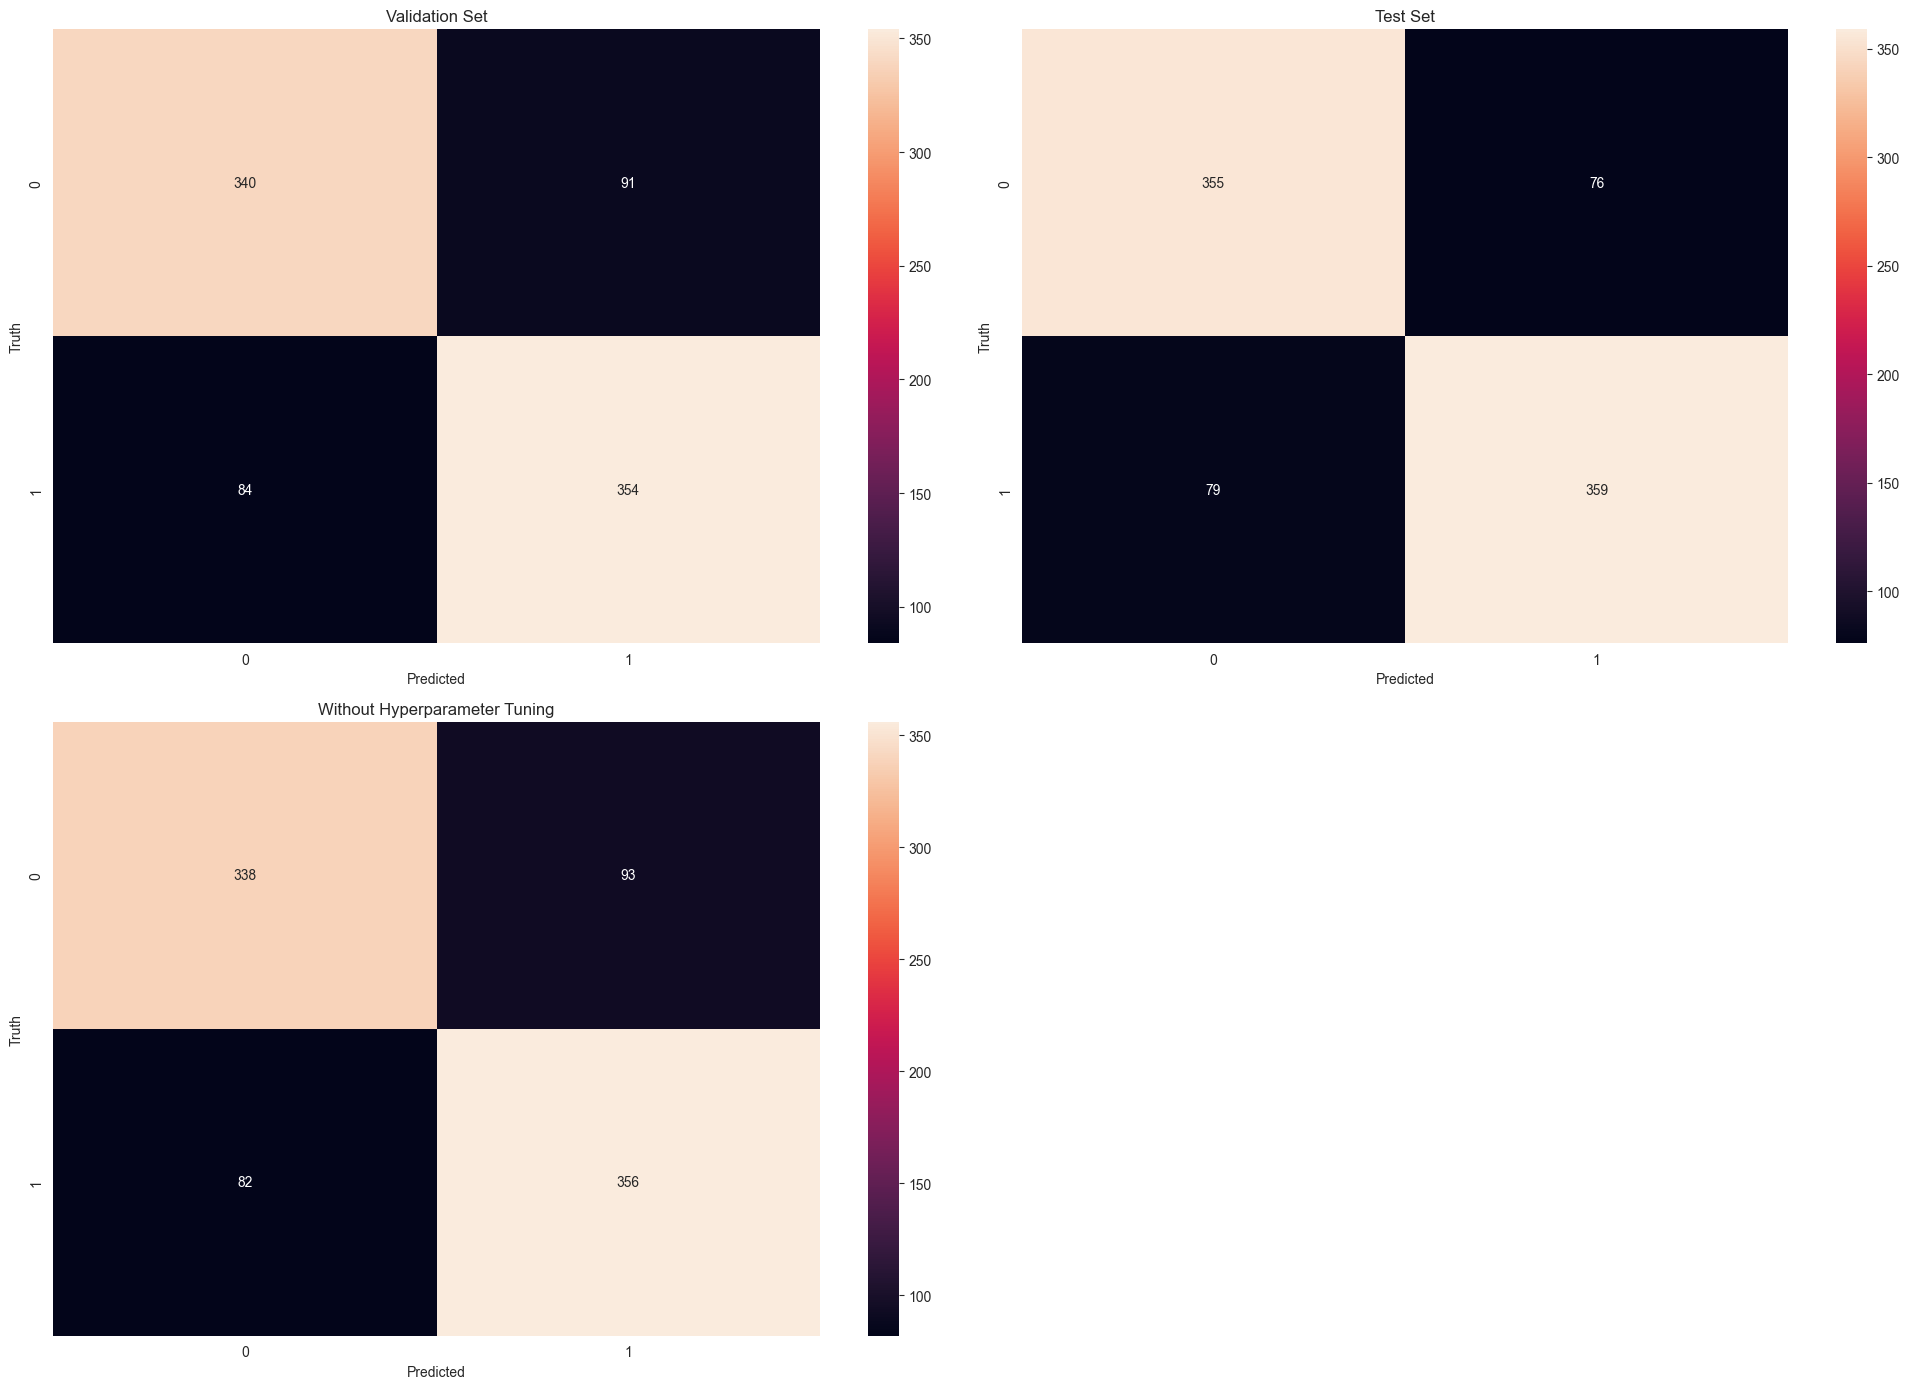

In [480]:
cat_model = models["CatBoostClassifier"]

y_pred_cat = cat_model.predict(X_val)

y_true_pred_list = [(y_val, y_pred_hyper), (y_test, y_pred_test), (y_val, y_pred_cat)]

title_list = ['Validation Set', 'Test Set', 'Without Hyperparameter Tuning']

helper.plot_multiple_confusion_matrices(y_true_pred_list, titles=title_list)

Model is making slightly more False positive errors than False negative errors in the validation set, but on the test set, it becomes more even

## ROC Curve

The Receiver Operating Characteristic (ROC) curve is a graphical tool used to assess the performance of a classifier. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. Each point on the ROC curve represents a different threshold value.

The Area Under the Curve (AUC) is a metric that quantifies the classifier's overall performance. It ranges from 0 to 1, with 1 indicating perfect discrimination and 0.5 indicating no better discrimination than random guessing.

When we plot the ROC curve and calculate the AUC score for a model, we aim to visualize its ability to distinguish between classes and identify the optimal classification threshold. The closer the curve is to the top left corner, the higher the AUC score, the better the model's performance. The ROC curve and AUC score provide a comprehensive view of the model's performance across all thresholds.

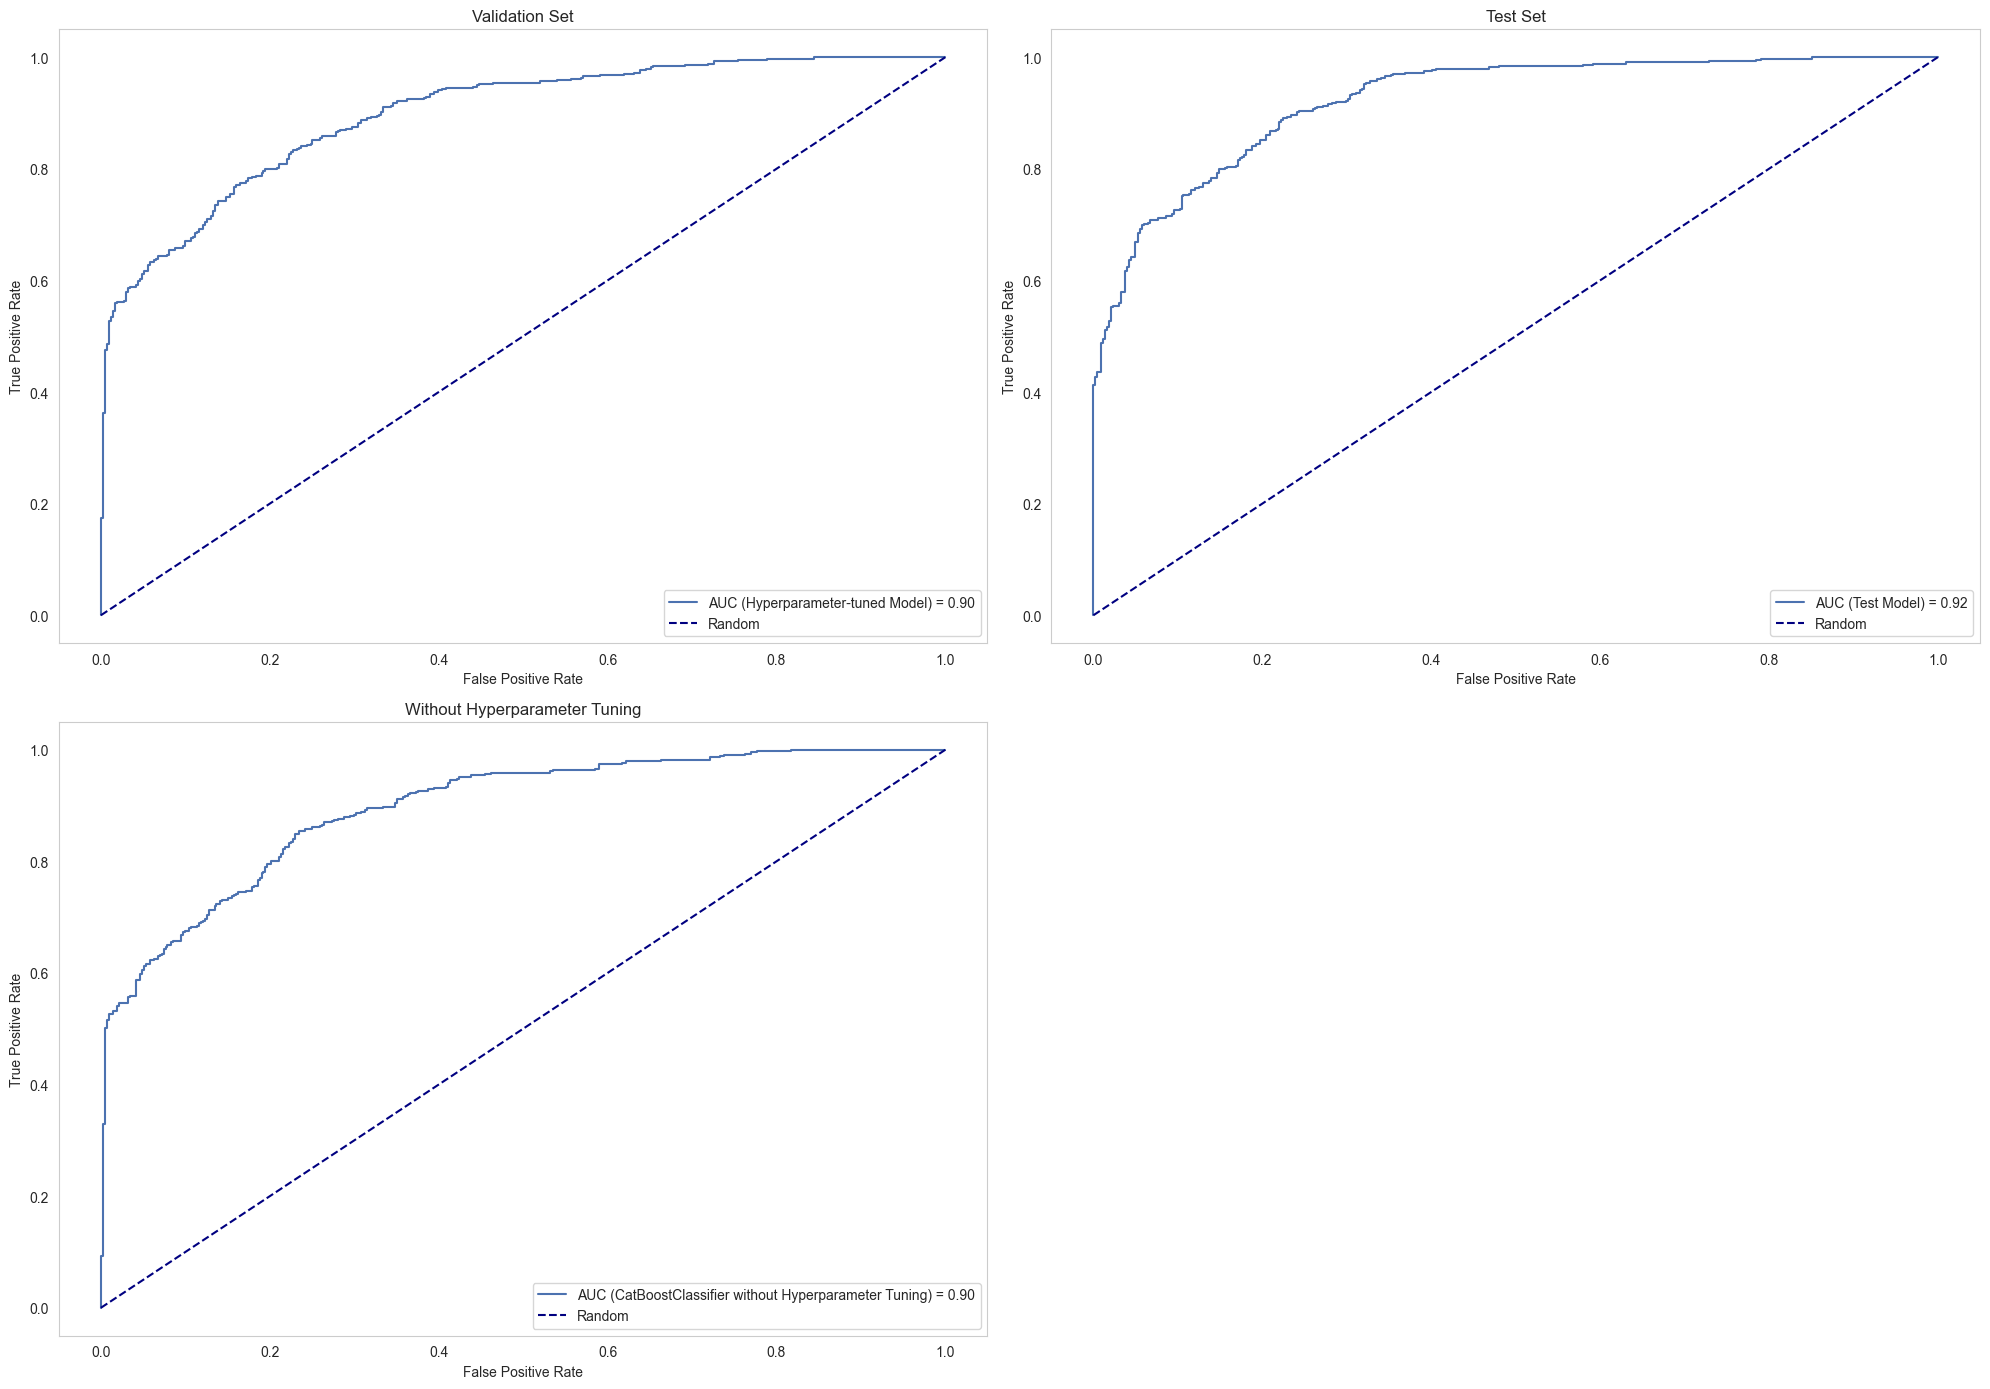

In [481]:
models_list = [best_model, best_model, cat_model]
model_names_list = ['Hyperparameter-tuned Model', 'Test Model', 'CatBoostClassifier without Hyperparameter Tuning']
X_tests_list = [X_val, X_test, X_val]
y_tests_list = [y_val, y_test, y_val]

helper.plot_multiple_roc_curves(models_list, model_names_list, X_tests_list, y_tests_list, titles=title_list)

# SHAP Values

SHAP (Shapley Additive explanations) is a way to understand how a machine learning model makes predictions. It uses ideas from game theory to explain how each feature contributes to a prediction.

SHAP values show how much a feature changes a prediction compared to if the feature was a basic or default value. They help us see how the model makes its predictions and show us which features are important in making these predictions.

Through the visual representation of SHAP values, we can embark on a visual journey, gaining a deeper understanding of the model's decision-making process. This visual exploration unveils the features that wield the most influence over the model's predictions.

We will calculate and show the SHAP values for our tuned CAT model. This will help us understand how it makes predictions and see which features are important in predicting the chance of a stroke.

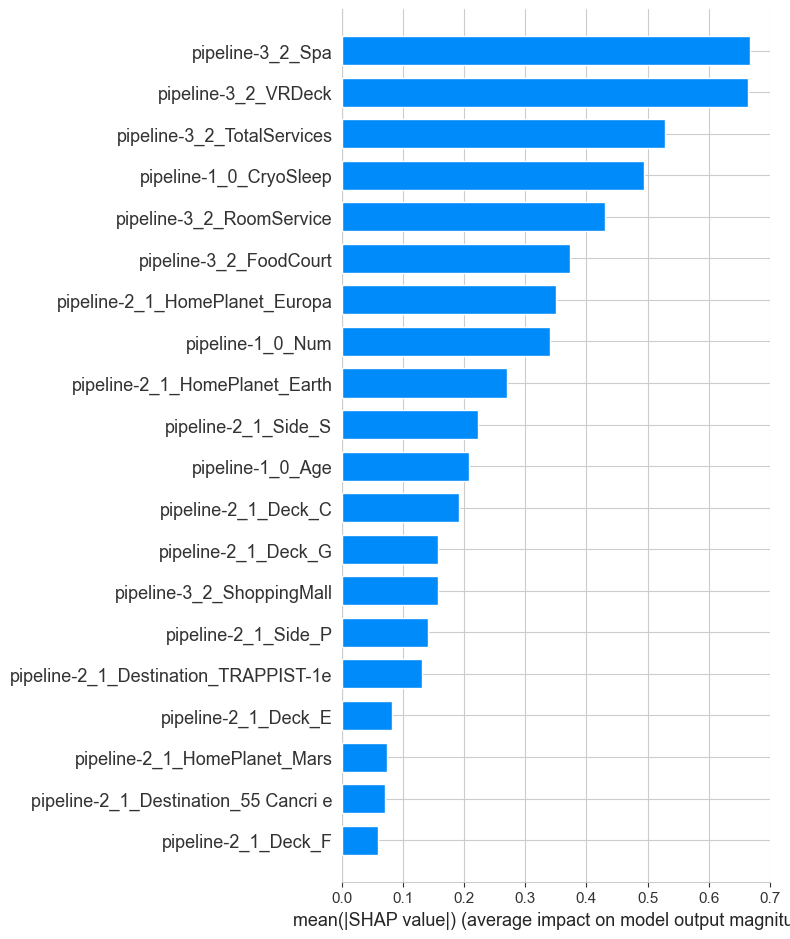

In [482]:
X_val_preprocessed = preprocessor.transform(X_val)

catboost_model = best_model.named_steps['catboostclassifier']

explainer = shap.Explainer(catboost_model)

shap_values = explainer.shap_values(X_val_preprocessed)

feature_names = []
unique_identifier = 0  

for transformer_name, transformer, columns in preprocessor.transformers_:
    if transformer_name != 'remainder':
        if hasattr(transformer, 'named_steps') and 'onehotencoder' in transformer.named_steps:
            encoded_features = transformer.named_steps['onehotencoder'].get_feature_names_out()
            prefixed_features = [f"{transformer_name}_{unique_identifier}_{feature}" for feature in encoded_features]
            feature_names.extend(prefixed_features)
            unique_identifier += 1 
        else:
            prefixed_features = [f"{transformer_name}_{unique_identifier}_{column}" for column in columns]
            feature_names.extend(prefixed_features)
            unique_identifier += 1  

shap.summary_plot(shap_values, X_val_preprocessed, feature_names=feature_names, plot_type="bar")

## Distribution of Classification Scores

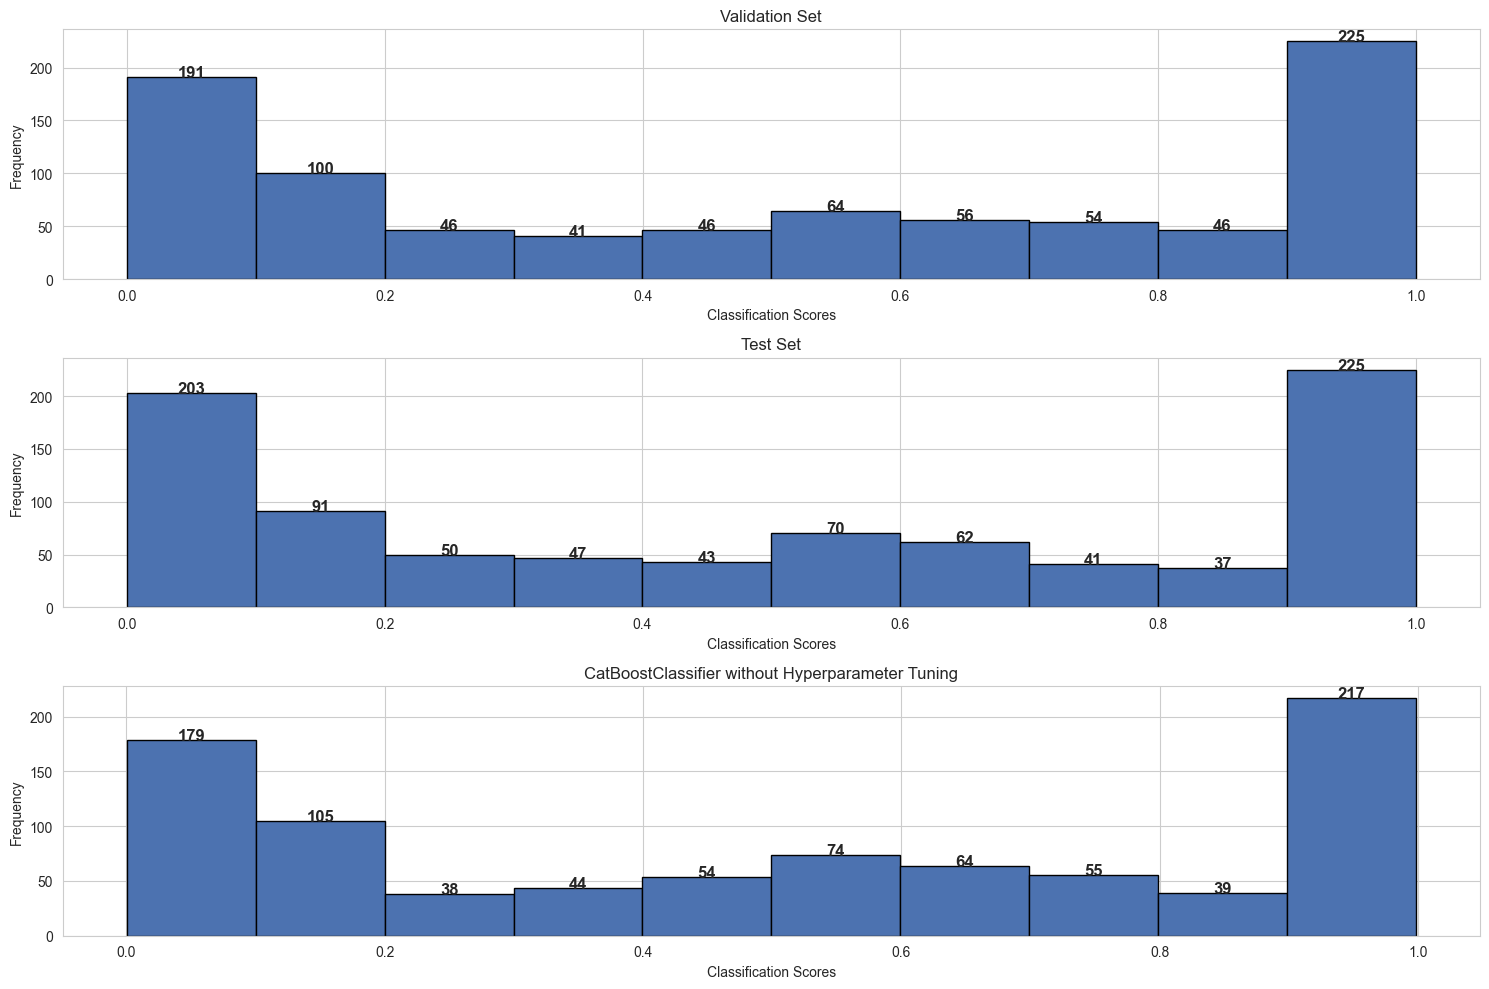

In [483]:
y_cat_model = cat_model.predict_proba(X_val)[:, 1]
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

helper.plot_classification_distribution([y_val_proba, y_test_proba, y_cat_model],
                                        ['Validation Set', 'Test Set', 'CatBoostClassifier without Hyperparameter Tuning'],
                                        figsize=(15, 10))

## Wrongly Classified Passengers

In [486]:
validation_full_df = helper.generate_predictions(best_model, X_val, y_val)
validation_full_df.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,...,CryoSleep_deck_BC,CryoSleep_destination_55,Age_Category,TotalServices,log_total_services,GroupSize,Actual,Predicted,Prob_Not_Transported,Prob_Transported
0,Earth,0.0,55 Cancri e,35.0,1.0,0.0,37.0,719.0,0.0,F,...,0,0,30-40,757.0,6-8,1,0,0,0.901105,0.098895
1,Mars,0.0,TRAPPIST-1e,73.0,27.0,2.0,71.0,1208.0,0.0,F,...,0,0,70-80,1308.0,6-8,1,0,0,0.964201,0.035799
2,Earth,1.0,55 Cancri e,51.0,0.0,0.0,0.0,0.0,0.0,G,...,0,1,50-60,0.0,0,1,1,1,0.036546,0.963454
3,Europa,0.0,TRAPPIST-1e,36.0,0.0,2345.0,0.0,1966.0,27.0,B,...,0,0,30-40,4338.0,8+,4,0,0,0.587258,0.412742
4,Earth,0.0,TRAPPIST-1e,20.0,0.0,4.0,429.0,0.0,287.0,G,...,0,0,15-20,720.0,6-8,3,0,0,0.828982,0.171018


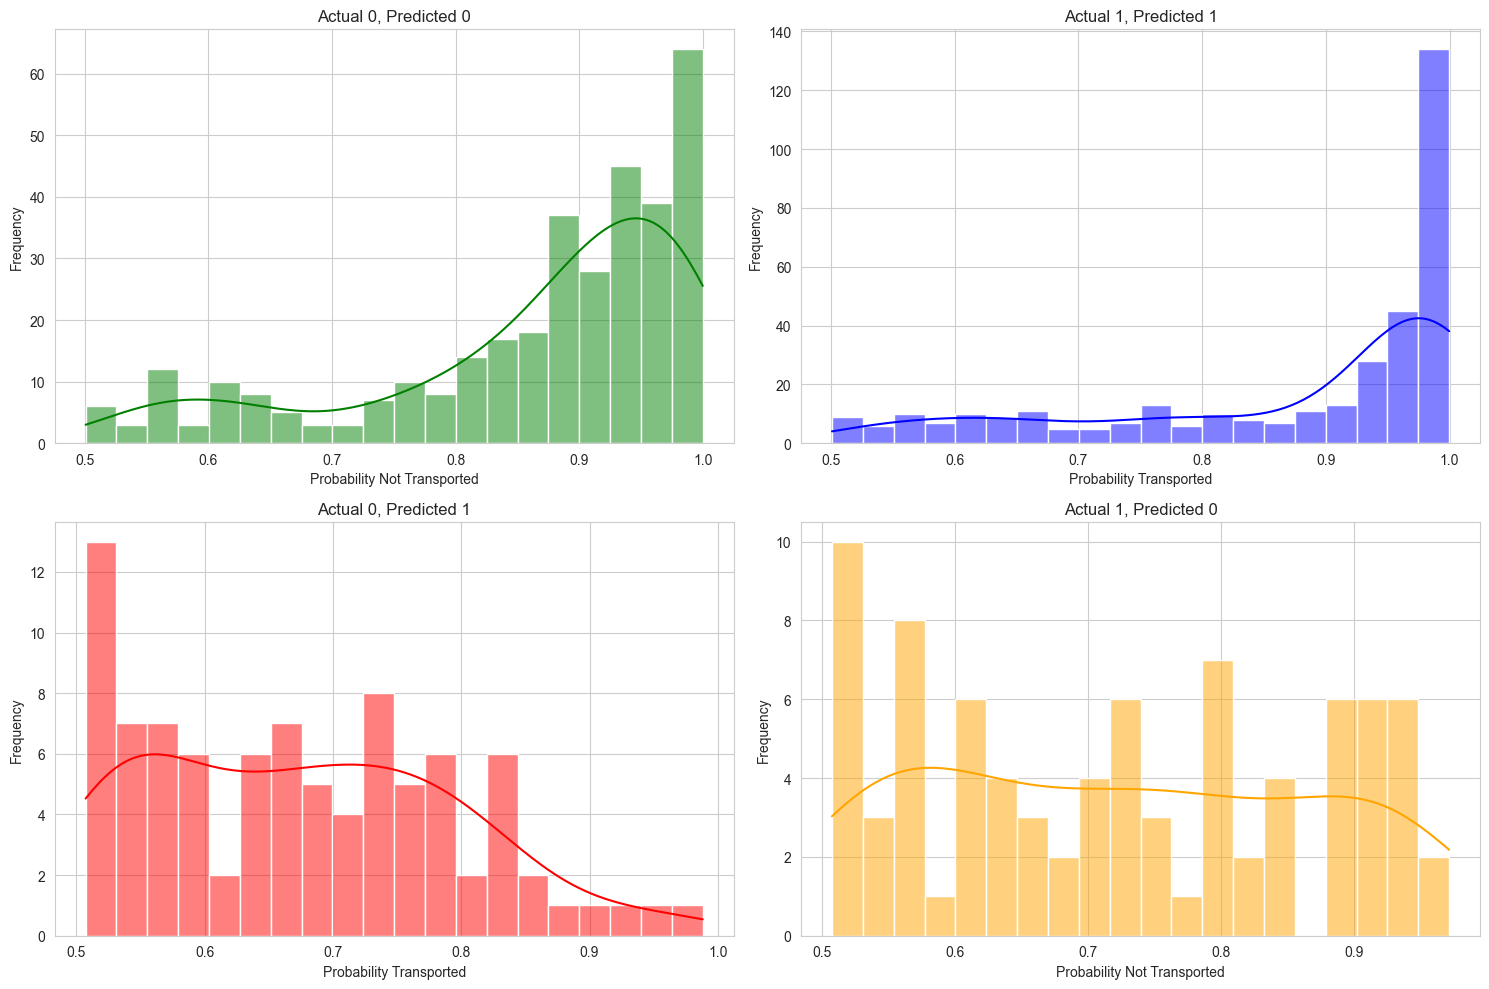

In [487]:
helper.plot_classification_probabilities(validation_full_df, figsize=(15, 10))

We can see that the model is overconfident in predicting 0s; many scores over 0.8 are wrongly classified. To understand why the model made incorrect predictions, we will now analyze the distribution of features for wrongly classified passengers.

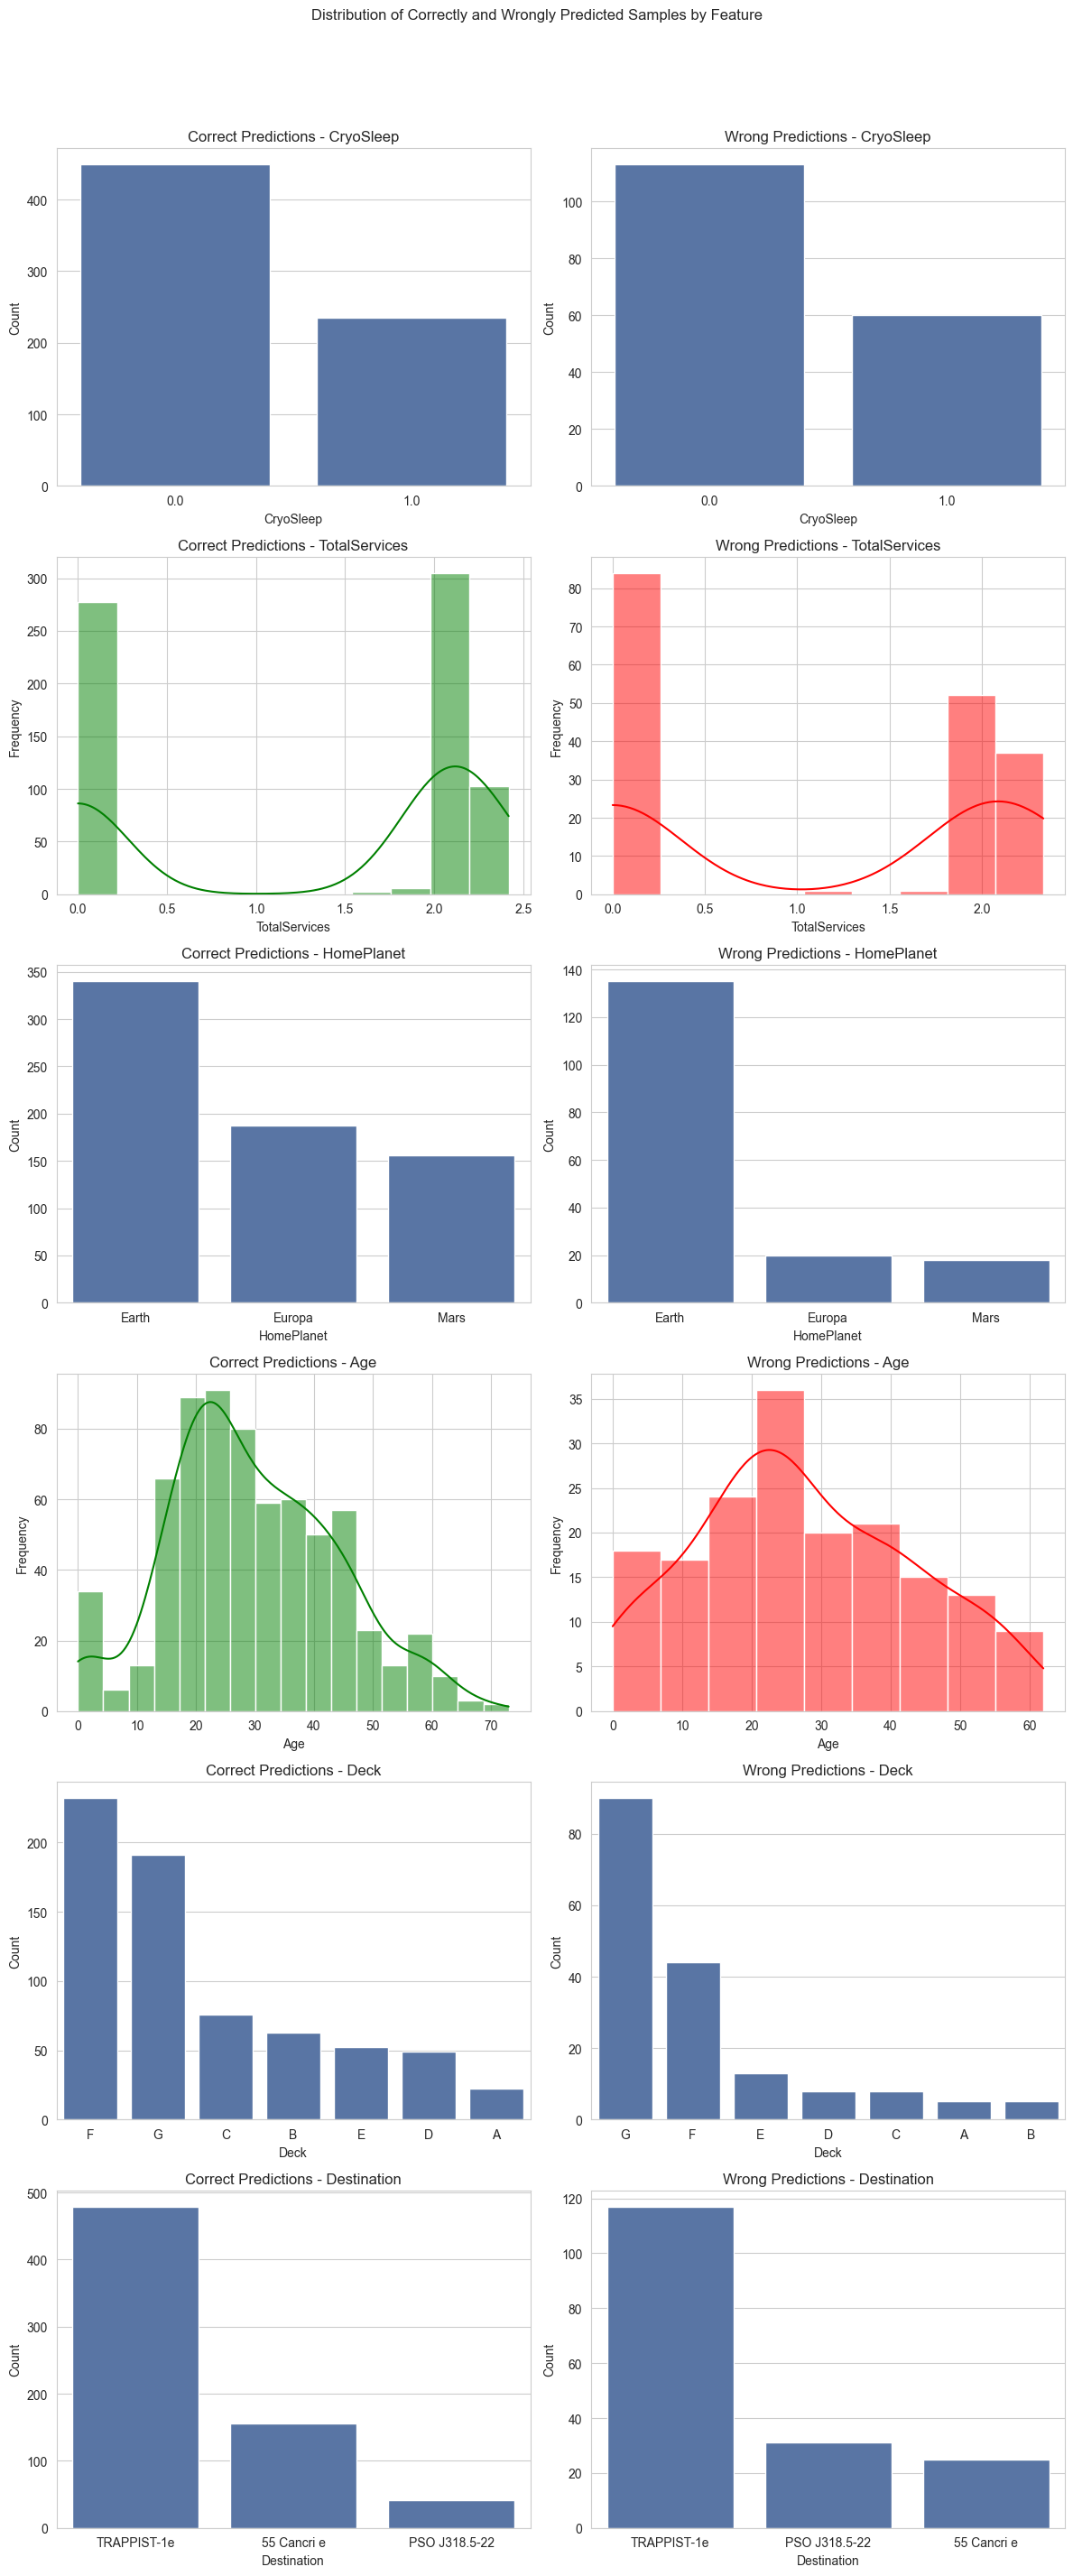

In [489]:
validation_full_df['TotalServices'] = np.log1p(validation_full_df['TotalServices'])

features = ['CryoSleep', 'TotalServices', 'HomePlanet', 'Age', 'Deck', 'Destination']

feature_types = ['categorical' if feature == 'CryoSleep' or validation_full_df[feature].dtype == 'object' or validation_full_df[feature].dtype.name == 'category' else 'numerical' for feature in features]

helper.plot_prediction_distributions(validation_full_df, features, feature_types)                           

These plots show that the model makes more wrong predictions when the home planet is Earth, the deck is G, and the destination PSO J318.5-22.

# Summary

The Titanic Spaceship project aimed to predict passenger outcomes in a futuristic scenario using the Kaggle Spaceship Titanic Dataset. The project aimed to surpass a 79% accuracy benchmark in predicting dimensional passenger transportation. The methodology included dataset exploration, data preprocessing, feature engineering, and evaluating various machine learning algorithms to optimize performance.

Key insights from the Exploratory Data Analysis (EDA) include:
The identification of predictive variables.
Handling of missing values.
The creation of new features based on existing data.
The dataset comprised numerical and categorical columns, with 'Transported' as the target boolean column. The data cleaning process was meticulous, carefully addressing null values, duplicates, and outliers. Feature engineering efforts focused on extracting meaningful information from the 'PassengerId' and 'Cabin' columns, among others.

Machine learning models included XGBoost, Random Forest, CatBoost, and LightGBM classifiers. The models were evaluated using recall, precision, F1 score, and accuracy metrics. The CatBoostClassifier, after hyperparameter tuning, only achieved the highest accuracy on the validation set and surpassed the project's accuracy goal after hyperparameter tuning. Further evaluation of the test set confirmed the model's effectiveness, achieving an accuracy of 81.5%. Kaggle test set accuracy was reached 81.201%. The project's success was evident in surpassing the accuracy goal, a significant achievement in predictive modeling.

The project also utilized SHAP values for model interpretation, providing insights into feature importance and the predictive model's decision-making process. Overall, the Titanic Spaceship project demonstrated the efficacy of machine learning in analyzing complex datasets and advancing predictive modeling techniques.

# Suggestions for improvment

After this project, several avenues for further improvement and exploration have been identified. These suggestions enhance the model's accuracy and provide more insightful predictions. Here are some potential areas for future work:

1. **Imputation of Missing Values**: To enhance the imputation of missing values, further exploration into the relationships between features could be beneficial. For instance, our analysis revealed a notable pattern: whenever the total services utilized by a passenger exceed 0, it invariably implies that the passenger was not in cryosleep. This insight can guide more accurate and logical imputation strategies. Such targeted imputation approaches can improve the dataset's integrity, potentially leading to more precise model predictions.

2. **Analysis of Specific Groups**: The model appears to make more mistakes for passengers whose home planet is Earth and who are located on deck G. A deeper investigation into this subgroup could reveal specific patterns or biases in the data that the current model overlooks. Understanding why these errors occur may lead to targeted improvements in the model or data preprocessing steps.

3. **Exploration of Deep Learning Techniques**: While traditional machine learning models have provided promising results, deep learning techniques could offer further improvements. Neural networks, especially those designed for tabular data, could capture complex interactions between features that could be more easily modeled with the current approach. Experimenting with architectures like deep feedforward networks, autoencoders for dimensionality reduction, or even transformer-based models for tabular data could uncover new insights.

4. **Further Feature Engineering**: There is always room to explore additional feature engineering techniques. Creating new features that capture more complex relationships within the target variable could enhance model performance. Techniques such as polynomial feature combinations, clustering-based features, or graph-based features (if applicable) might reveal new patterns.

By pursuing these suggestions, the project could achieve higher accuracy and provide more reliable and interpretable predictions, potentially uncovering new insights into the data and the phenomena it represents.